In [1]:
import matplotlib.pyplot as plt
import numpy as np 
from math import sqrt 
from math import floor
from math import ceil
from math import exp 
import pickle
from operator import itemgetter
import time
from datetime import timedelta
import matplotlib
from matplotlib import cm, colors
from numpy import amin, amax, ravel

import pickle


In [2]:
def get_all_saws(current_paths, length, current_conformation):
    """ Все созданные конформации лежат в первом аргументе функции get_all_saws, 
    поэтому первым аргументом нужно подавать переменную, которой ранее присвоили пустой список
    
    """
    if(length==1):
        current_paths.append(current_conformation)
    else:
        for step in [(1, 0), (-1, 0), (0, 1),  (0, -1)]:
            new_point = (current_conformation[-1][0]+step[0], current_conformation[-1][1]+step[1] )
            if new_point in current_conformation:
                continue
            else:
                temp_path = current_conformation.copy()
                temp_path.append(new_point)
                get_all_saws(current_paths, length-1,  temp_path)

In [3]:
def get_sequences(length):
    """Получаем все последовательности заданной длины, состоящие из 0 и 1.
    1 - это H
    0 - это Р"""
    if(length ==1):
        return [[-1], [1]]
    else:
        previous = get_sequences(length - 1)
        result = [] 
        for i in range(len(previous)):
            current = previous[i].copy()
            current.append(-1)
            result.append(current.copy())
            current[-1] = 1
            result.append(current)
            #print(result) 
        return sorted(result)

In [4]:
def end_to_end_distance(path):
    """Евклидова метрика"""
    distance = (path[-1][0]-path[0][0])**2+(path[-1][1]-path[0][1])**2   
    return distance 

In [5]:
steps = [(1, 0), (-1, 0), (0, 1),  (0, -1)]
def Ising_energy1(saw, seq):
    """Функция принимает на вход конформацию на плоскости(список координат). 
    Возвращает число топологических соседей для нее """
    k=0
    for i in range(1, len(saw)-1):
        not_topological=[saw[i-1], saw[i+1]]
        for step in steps:
            new_point = (saw[i][0]+step[0], saw[i][1]+step[1] )
            if (new_point in saw and (new_point not in not_topological)):
                position = saw.index(new_point)
                k=k+seq[i]*seq[position]
    for step in steps:
        new_point_begin = (saw[0][0]+step[0], saw[0][1]+step[1] )
        new_point_end= ( saw[-1][0]+step[0], saw[-1][1]+step[1])
        
        if(new_point_begin in saw and new_point_begin!=saw[1]):
            position = saw.index(new_point_begin)
            k=k+seq[0]*seq[position]
 
        if( new_point_end in saw and new_point_end!=saw[-2]    ):
            position = saw.index(new_point_end)
            k=k+seq[-1]*seq[position]
        
        
    #print(k)
    return k//2

In [6]:
steps = [(1, 0), (-1, 0), (0, 1),  (0, -1)]
def Ising_energy(saw, seq):
    """Функция принимает на вход конформацию на плоскости(список координат). 
    Возвращает число топологических соседей для нее """
    k=0
    for i in range(1, len(saw)-1):
        not_topological=[saw[i-1], saw[i+1]]
        for step in steps:
            new_point = (saw[i][0]+step[0], saw[i][1]+step[1] )
            if (new_point in saw    ):
                position = saw.index(new_point)
                k=k+seq[i]*seq[position]
    for step in steps:
        new_point_begin = (saw[0][0]+step[0], saw[0][1]+step[1] )
        new_point_end= ( saw[-1][0]+step[0], saw[-1][1]+step[1])
        
        if(new_point_begin in saw ):
            position = saw.index(new_point_begin)
            k=k+seq[0]*seq[position]
 
        if( new_point_end in saw    ):
            position = saw.index(new_point_end)
            k=k+seq[-1]*seq[position]
        
        
    #print(k//2)
    return k//2

In [7]:
h=2
def calc_r (eps, f = 8):

    mean_c_l = []
    
    for i in range(4, f+1):
        seq = get_sequences(i)
        conformat = []

        start_conformation = [(0,0)]
        get_all_saws(conformat, i ,start_conformation)

        Z = 0.0
        R_sum = 0.0

        for l in range(len(conformat)):
            for j in range(len(seq)):
                E = Ising_energy(conformat[l], seq[j])
                Z = Z + np.exp(-(-eps*E-h*np.sum(seq[j])))
                r = end_to_end_distance(conformat[l])
                R_sum = R_sum + np.exp(-(-eps*E-h*np.sum(seq[j])))*r

        mean_c_l.append(R_sum/Z)
        
 
            
        print(i)
        print(R_sum,Z)
        print(R_sum/Z)
        
        
    fn = 'Ising/radiues1'+str(eps)+'.pickle'
    with open(fn, 'wb') as f:
        pickle.dump(mean_c_l, f)        
        
    

In [53]:
steps = [(1, 0), (-1, 0), (0, 1),  (0, -1)]

def count_saws_contact(saws):
    """Функция принимает список блужданий на плоскости. Возвращает словарь, в котором ключ - число топологических соседей,
    а значение - число таких конформаций.
    Максимальное число топологических соседей находится по формуле из [1]"""
    n=len(saws[0])
    
    n2 = 0
    n3 = 0
    n4 = 0 
    n_2 = []
    n_3 = []
    n_4 = []
    counts ={}
    for i in range(n):
        counts.update({i :0})
    for saw in saws:
        n2 = 0
        n3 = 0
        n4 = 0 
        for i in range(n):
            k=0
            for step in steps:
                new_point = (saw[i][0]+step[0], saw[i][1]+step[1] )
                if (new_point in saw ):
                    k+=1
            if(k==2):
                n2+=1
            if(k==3):
                n3+=1
            if(k==4):
                n4+=1
        n_2.append(n2/n)
        n_3.append(n3/n)
        n_4.append(n4/n)
 
    n2 = np.mean(n_2)
    n3 = np.mean(n_3)
    n4 = np.mean(n_4)
                
        
    return np.array([n2,n3,n4])#{2:n2, 3:n3, 4:n4}

In [54]:
conformat = []

start_conformation = [(0,0)]

conf_10 = get_all_saws(conformat, 10,start_conformation)

In [55]:
d = count_saws_contact(conformat)
d

array([0.67223998, 0.16139661, 0.01475289])

In [57]:
sum(d), 

(0.8483894762724367,)

Text(0.5, 1.0, 'N=10')

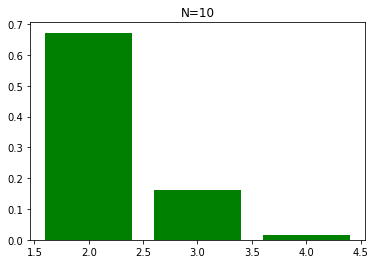

In [59]:
plt.bar(np.arange(2,5), d, color='g')
plt.title("N=10")


Text(0.5, 1.0, 'N=11')

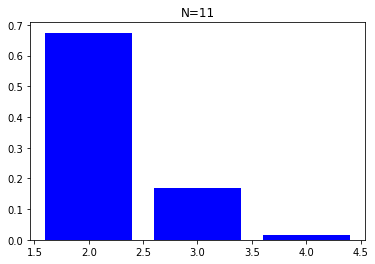

In [66]:
conformat = []

start_conformation = [(0,0)]

conf_10 = get_all_saws(conformat, 11,start_conformation)
d1 = count_saws_contact(conformat)

plt.bar(np.arange(2,5), d1, color='b')
plt.title("N=11")


In [68]:
d1

array([0.67457431, 0.16874047, 0.01668934])

Text(0.5, 1.0, 'N=12')

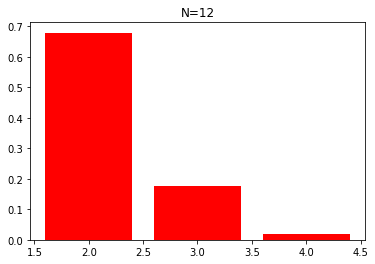

In [65]:
conformat = []

start_conformation = [(0,0)]

conf_10 = get_all_saws(conformat, 12,start_conformation)
d2 = count_saws_contact(conformat)

plt.bar(np.arange(2,5), d2, color='r')
plt.title("N=12")

In [69]:
d2

array([0.67956306, 0.17658143, 0.01841076])

In [64]:
sum(d2)

0.8745552488943571

In [18]:
calc_r(0.5, 8)

4
1043382.4994599628 253229.27719809744
4.120307537124708
5
47272083.72277269 7434353.981538239
6.358600066685504
6
1957690915.608241 243437927.59644663
8.041848429031798
7
76185140527.49658 7174605636.023416
10.618721696001513
8
2861155119277.486 231634939474.70267
12.352001497554554


In [19]:
calc_r(0.8, 9)

4
2598818.097541389 683137.0509246505
3.8042411753597545
5
165516009.1705736 28005402.686641835
5.91014566091286
6
9835616333.268118 1402418774.4025807
7.013323347341818
7
548281981076.4695 58370467362.97512
9.393140158823696
8
30016208965515.15 2924246389618.999
10.26459640065623


KeyboardInterrupt: 

In [8]:
def center_of_mass(conformation):
    """Функция для нахождения координат центра масс.
    Подразумевается, что все аминокислоты в молекуле одинаковой массы, а между ними ничего с массой нет.
    Принимает конформацию - список из координат, возвращает координаты в виде коортежа.
    """
    x=0
    y=0
    for i in range(len(conformation)):
        x=x+(conformation[i][0]-conformation[0][0])
        y=y+(conformation[i][1]-conformation[0][1])
        
    return (x/len(conformation), y/len(conformation)) 

def square_radius_of_gyration(conformation):
    """Функция возвращает радиус вращения для данной конформации """
    cent_mass=center_of_mass(conformation)
    summa=0
    for i in range(len(conformation)):
        dist = (conformation[i][0]-cent_mass[0],  conformation[i][1]-cent_mass[1])
        summa=summa+dist[0]*dist[0]+dist[1]*dist[1]
    return summa/len(conformation)
    

In [9]:
def calc_r_gyration (eps, f = 8):

    mean_c_l = []
    
    for i in range(4, f+1):
        seq = get_sequences(i)
        conformat = []

        start_conformation = [(0,0)]
        get_all_saws(conformat, i ,start_conformation)

        Z = 0.0
        R_sum = 0.0

        for l in range(len(conformat)):
            for j in range(len(seq)):
                E = Ising_energy(conformat[l], seq[j])
                Z = Z + np.exp(-eps*E)
                r = square_radius_of_gyration(conformat[l])
                R_sum = R_sum + np.exp(-eps*E)*r

        mean_c_l.append(R_sum/Z)
        
 
            
        print(i)
        print(R_sum,Z, R_sum/Z)
        
        
    fn = 'Ising/radiues1'+str(eps)+'_gyr.pickle'
    with open(fn, 'wb') as f:
        pickle.dump(mean_c_l, f)        
        

In [13]:
calc_r_gyration(0.5, 9)

4
681.7238821435777 858.742463331268 0.7938630162749927
5
6213.934097431552 5470.247184080317 1.135951244674196
6
53967.83337974882 36469.462495951164 1.479808850644298
7
433974.42794130195 230746.3218309893 1.8807425596112755
8
3430048.223825537 1507905.6345244353 2.2747101312525495
9
25876275.96334907 9492969.084872395 2.7258359036041147


In [10]:
calc_r_gyration(0.8, 9)

4
1201.5115397967031 1560.928903075966 0.7697413619729924
5
13393.665052724224 12196.1421903517 1.0981886602896347
6
148709.32843590336 106530.50121774133 1.3959319325077733
7
1478559.1895109913 836004.8171040502 1.7686012798739268
8
15060256.620164337 7210703.25405901 2.0885974764925597
9
142006079.74203935 57056848.58054875 2.4888524914159147


In [16]:
calc_r(0, 9)

4
2624.0 576.0
5
22528.0 3200.0
6
173824.0 18176.0
7
1255424.0 99840.0
8
8649728.0 556032.0
9
57589760.0 3028992.0


In [9]:
calc_r(0, 9)

4
2624.0 576.0
5
22528.0 3200.0
6
173824.0 18176.0
7
1255424.0 99840.0
8
8649728.0 556032.0
9
57589760.0 3028992.0


In [9]:
calc_r(0.5, 9)


4
2301314.7671979447 559102.5589982035
4.116086986476017
5
127225222.20031191 20022237.357214194
6.354196083609583
6
6429960937.67582 800525389.4827659
8.032176146006233
7
305342776295.6921 28781448383.5583
10.609013564102712
8
13994564463899.232 1134493693507.6902
12.335515432113215
9
620855601333435.1 41043134031759.05
15.12690529073679


In [10]:
calc_r(0.5, 9)

4
3795.209668892801 858.742463331268
5
37312.923012477615 5470.247184080317
6
331093.8458863125 36469.462495951164
7
2754353.1265523713 230746.3218309893
8
21914197.889178168 1507905.6345244353
9
168616103.63162214 9492969.084872395


In [18]:
calc_r(0.8, 9)


4
2667.1916731270217 619.1916731270205
5
23564.60015504843 3545.5333850161933
6
188630.015635034 21691.75723609176
7
1417002.4756924948 123819.65726853596
8
10206165.11825616 743246.7419526328
9
71123942.77211504 4234400.026969783


In [11]:
calc_r(0.8, 9)

4
6460.385930086536 1560.928903075966
5
77952.37717293733 12196.1421903517
6
860239.0706876665 106530.50121774133
7
8918268.76338377 836004.8171040502
8
89298294.74877487 7210703.25405901
9
865641491.5100735 57056848.58054875


In [19]:
calc_r(1.3, 9)

4
2748.277021481804 700.2770214818084
5
25510.648515563735 4194.216171854423
6
218945.16564905495 29551.65089116937
7
1764426.8843524102 178914.61306710588
8
13852065.182455745 1251987.7692973707
9
105179763.76126094 7710227.959430352


In [12]:
calc_r(1.3, 9)

4
22105.87517150113 6426.3420133735535
5
435316.2680159763 80080.32855429556
6
8335701.681888831 1418683.5275521083
7
147784967.43690336 18166659.024148706
8
2684658640.3004537 333091986.3716222
9
46704209216.32553 4587856888.732316
